# 论文28：开放域问答的密集通道检索
## Vladimir Karpukhin, Barlas Oğuz, Sewon Min, et al., Meta AI (2020)

### 密集通道检索 (DPR)

学习问题和段落的密集嵌入。通过嵌入空间中的相似性检索。击败 BM25！

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 双编码器架构

```
问题 → 编码器_Q → q (密集向量)
段落 → 编码器_P → p (密集向量)

相似度: sim(q, p) = q · p  (点积)
```

In [2]:
class SimpleTextEncoder:
    """Simplified text encoder (in practice: use BERT)"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Embeddings
        self.embeddings = np.random.randn(vocab_size, embedding_dim) * 0.01
        
        # Simple RNN weights
        self.W_xh = np.random.randn(hidden_dim, embedding_dim) * 0.01
        self.W_hh = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.b_h = np.zeros((hidden_dim, 1))
        
        # Output projection
        self.W_out = np.random.randn(hidden_dim, hidden_dim) * 0.01
    
    def encode(self, token_ids):
        """
        Encode sequence of token IDs to dense vector
        Returns: dense embedding (hidden_dim,)
        """
        h = np.zeros((self.hidden_dim, 1))
        
        # Process tokens
        for token_id in token_ids:
            # Lookup embedding
            x = self.embeddings[token_id].reshape(-1, 1)
            
            # RNN step
            h = np.tanh(np.dot(self.W_xh, x) + np.dot(self.W_hh, h) + self.b_h)
        
        # Final representation (CLS-like)
        output = np.dot(self.W_out, h).flatten()
        
        # L2 normalize for cosine similarity
        output = output / (np.linalg.norm(output) + 1e-8)
        
        return output

# Create encoders
vocab_size = 1000
embedding_dim = 64
hidden_dim = 128

question_encoder = SimpleTextEncoder(vocab_size, embedding_dim, hidden_dim)
passage_encoder = SimpleTextEncoder(vocab_size, embedding_dim, hidden_dim)

# Test
test_tokens = [10, 25, 37, 42]
q_emb = question_encoder.encode(test_tokens)
p_emb = passage_encoder.encode(test_tokens)

print(f"Question embedding shape: {q_emb.shape}")
print(f"Passage embedding shape: {p_emb.shape}")
print(f"Similarity (dot product): {np.dot(q_emb, p_emb):.4f}")

Question embedding shape: (128,)
Passage embedding shape: (128,)
Similarity (dot product): 0.0155


## 合成 QA 数据集

In [3]:
class SimpleTokenizer:
    """Simple word tokenizer"""
    def __init__(self):
        self.word_to_id = {}
        self.id_to_word = {}
        self.next_id = 0
    
    def tokenize(self, text):
        """Convert text to token IDs"""
        words = text.lower().split()
        token_ids = []
        
        for word in words:
            if word not in self.word_to_id:
                self.word_to_id[word] = self.next_id
                self.id_to_word[self.next_id] = word
                self.next_id += 1
            token_ids.append(self.word_to_id[word])
        
        return token_ids

# Create synthetic dataset
passages = [
    "The Eiffel Tower is a wrought-iron lattice tower in Paris, France.",
    "The Great Wall of China is a series of fortifications in northern China.",
    "The Statue of Liberty is a colossal neoclassical sculpture in New York.",
    "The Colosseum is an oval amphitheatre in the centre of Rome, Italy.",
    "The Taj Mahal is an ivory-white marble mausoleum in Agra, India.",
    "Mount Everest is Earth's highest mountain above sea level.",
    "The Amazon River is the largest river by discharge volume of water.",
    "The Sahara is a desert on the African continent.",
]

questions = [
    ("What is the Eiffel Tower?", 0),  # (question, relevant_passage_idx)
    ("Where is the Great Wall located?", 1),
    ("What is the tallest mountain?", 5),
    ("Where is the Statue of Liberty?", 2),
    ("What is the largest river?", 6),
]

# Tokenize
tokenizer = SimpleTokenizer()

passage_tokens = [tokenizer.tokenize(p) for p in passages]
question_tokens = [(tokenizer.tokenize(q), idx) for q, idx in questions]

print("Sample passage:")
print(f"Text: {passages[0]}")
print(f"Tokens: {passage_tokens[0][:10]}...")
print(f"\nVocabulary size: {tokenizer.next_id}")

Sample passage:
Text: The Eiffel Tower is a wrought-iron lattice tower in Paris, France.
Tokens: [0, 1, 2, 3, 4, 5, 6, 2, 7, 8]...

Vocabulary size: 67


## 编码语料库和问题

In [4]:
# Re-initialize encoders with correct vocab size
vocab_size = tokenizer.next_id
question_encoder = SimpleTextEncoder(vocab_size, embedding_dim=32, hidden_dim=64)
passage_encoder = SimpleTextEncoder(vocab_size, embedding_dim=32, hidden_dim=64)

# Encode all passages
passage_embeddings = []
for tokens in passage_tokens:
    emb = passage_encoder.encode(tokens)
    passage_embeddings.append(emb)
passage_embeddings = np.array(passage_embeddings)

# Encode questions
question_embeddings = []
for tokens, _ in question_tokens:
    emb = question_encoder.encode(tokens)
    question_embeddings.append(emb)
question_embeddings = np.array(question_embeddings)

print(f"Passage embeddings: {passage_embeddings.shape}")
print(f"Question embeddings: {question_embeddings.shape}")

Passage embeddings: (8, 64)
Question embeddings: (5, 64)


## 通过最大内积搜索 (MIPS) 进行密集检索

In [5]:
def retrieve_top_k(query_embedding, passage_embeddings, k=3):
    """
    Retrieve top-k passages for query
    Uses dot product similarity (MIPS)
    """
    # Compute similarities
    similarities = np.dot(passage_embeddings, query_embedding)
    
    # Get top-k indices
    top_k_indices = np.argsort(similarities)[::-1][:k]
    top_k_scores = similarities[top_k_indices]
    
    return top_k_indices, top_k_scores

# Test retrieval
print("\nDense Retrieval Results:\n" + "="*80)
for i, (q_tokens, correct_idx) in enumerate(question_tokens):
    question_text = questions[i][0]
    q_emb = question_embeddings[i]
    
    # Retrieve
    top_indices, top_scores = retrieve_top_k(q_emb, passage_embeddings, k=3)
    
    print(f"\nQ: {question_text}")
    print(f"Correct passage: #{correct_idx}")
    print(f"\nRetrieved (top-3):")
    for rank, (idx, score) in enumerate(zip(top_indices, top_scores), 1):
        is_correct = "✓" if idx == correct_idx else "✗"
        print(f"  {rank}. [{is_correct}] (score={score:.3f}) {passages[idx][:60]}...")

print("\n" + "="*80)
print("(Encoders are untrained, so results are random)")


Dense Retrieval Results:

Q: What is the Eiffel Tower?
Correct passage: #0

Retrieved (top-3):
  1. [✓] (score=0.132) The Eiffel Tower is a wrought-iron lattice tower in Paris, F...
  2. [✗] (score=0.058) The Statue of Liberty is a colossal neoclassical sculpture i...
  3. [✗] (score=-0.018) The Sahara is a desert on the African continent....

Q: Where is the Great Wall located?
Correct passage: #1

Retrieved (top-3):
  1. [✓] (score=0.299) The Great Wall of China is a series of fortifications in nor...
  2. [✗] (score=0.267) The Colosseum is an oval amphitheatre in the centre of Rome,...
  3. [✗] (score=0.068) Mount Everest is Earth's highest mountain above sea level....

Q: What is the tallest mountain?
Correct passage: #5

Retrieved (top-3):
  1. [✓] (score=0.351) Mount Everest is Earth's highest mountain above sea level....
  2. [✗] (score=0.269) The Amazon River is the largest river by discharge volume of...
  3. [✗] (score=0.181) The Taj Mahal is an ivory-white marble mausoleum 

## 使用批内负样本进行训练

In [6]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Numerical stability
    return exp_x / np.sum(exp_x)

def contrastive_loss(query_emb, positive_emb, negative_embs):
    """
    Contrastive loss (InfoNCE)
    
    L = -log( exp(q·p+) / (exp(q·p+) + Σ exp(q·p-)) )
    """
    # Positive score
    pos_score = np.dot(query_emb, positive_emb)
    
    # Negative scores
    neg_scores = [np.dot(query_emb, neg_emb) for neg_emb in negative_embs]
    
    # All scores
    all_scores = np.array([pos_score] + neg_scores)
    
    # Softmax
    probs = softmax(all_scores)
    
    # Negative log likelihood (positive should be first)
    loss = -np.log(probs[0] + 1e-8)
    
    return loss

# Simulate training batch
batch_size = 3
batch_questions = question_embeddings[:batch_size]
batch_passages = passage_embeddings[:batch_size]

# In-batch negatives: for each question, other passages in batch are negatives
total_loss = 0
print("\nIn-Batch Negative Training:\n" + "="*80)
for i in range(batch_size):
    q_emb = batch_questions[i]
    pos_emb = batch_passages[i]  # Correct passage
    
    # Negatives: all other passages in batch
    neg_embs = [batch_passages[j] for j in range(batch_size) if j != i]
    
    loss = contrastive_loss(q_emb, pos_emb, neg_embs)
    total_loss += loss
    
    print(f"Question {i}: loss = {loss:.4f}")

avg_loss = total_loss / batch_size
print(f"\nAverage batch loss: {avg_loss:.4f}")
print("\nIn-batch negatives: efficient hard negative mining!")


In-Batch Negative Training:
Question 0: loss = 0.9869
Question 1: loss = 0.9194
Question 2: loss = 1.1522

Average batch loss: 1.0195

In-batch negatives: efficient hard negative mining!


## 可视化嵌入空间

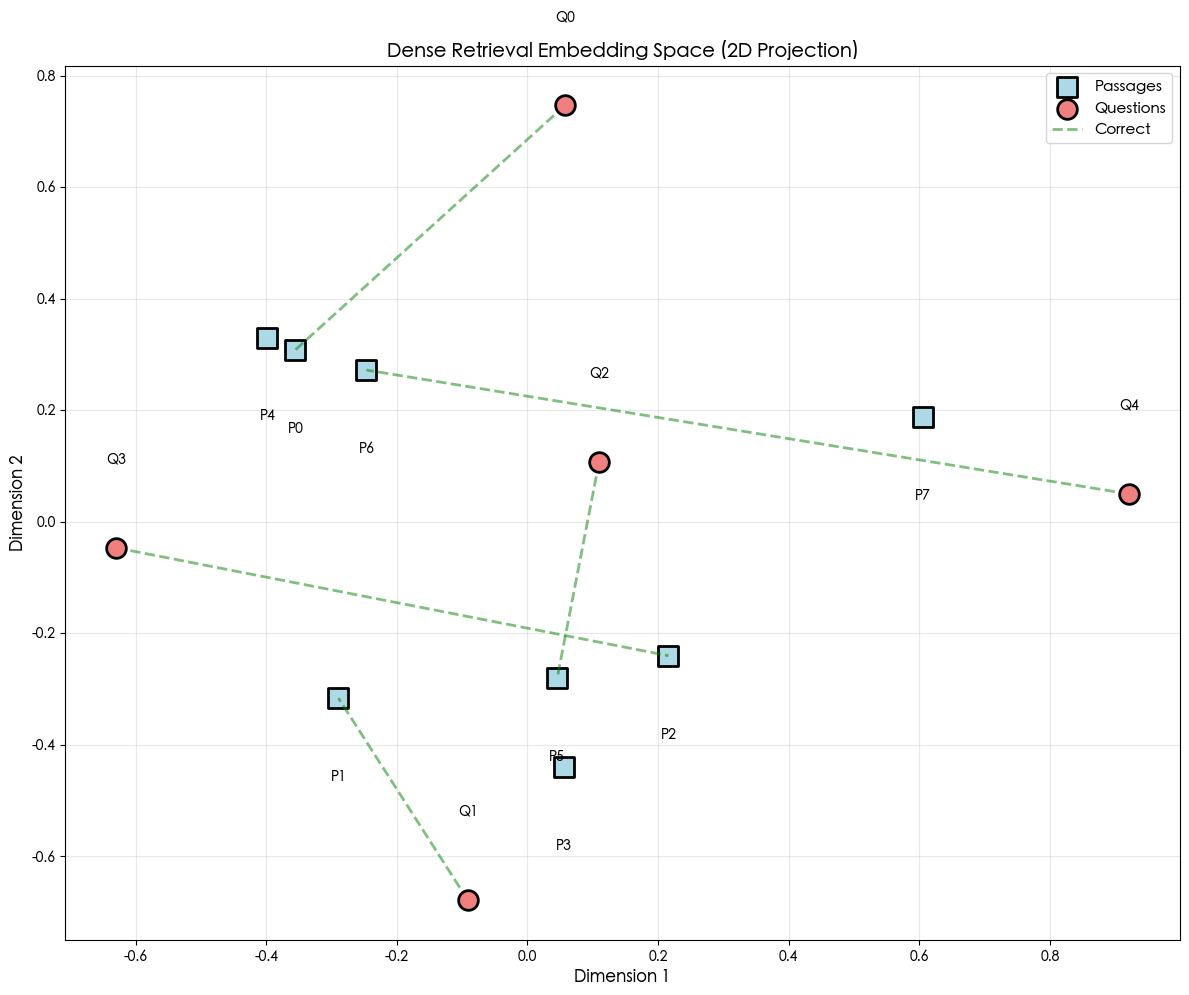


Ideal: Questions close to their relevant passages!


In [7]:
# Simple 2D projection (PCA-like)
def project_2d(embeddings):
    """Project high-dim embeddings to 2D (simplified PCA)"""
    # Mean center
    mean = np.mean(embeddings, axis=0)
    centered = embeddings - mean
    
    # Take first 2 principal components (simplified)
    U, S, Vt = np.linalg.svd(centered, full_matrices=False)
    projected = U[:, :2] * S[:2]
    
    return projected

# Project to 2D
all_embeddings = np.vstack([passage_embeddings, question_embeddings])
projected = project_2d(all_embeddings)

passage_2d = projected[:len(passage_embeddings)]
question_2d = projected[len(passage_embeddings):]

# Visualize
plt.figure(figsize=(12, 10))

# Plot passages
plt.scatter(passage_2d[:, 0], passage_2d[:, 1], s=200, c='lightblue', 
           edgecolors='black', linewidths=2, marker='s', label='Passages', zorder=2)

# Annotate passages
for i, (x, y) in enumerate(passage_2d):
    plt.text(x, y-0.15, f'P{i}', ha='center', fontsize=10, fontweight='bold')

# Plot questions
plt.scatter(question_2d[:, 0], question_2d[:, 1], s=200, c='lightcoral', 
           edgecolors='black', linewidths=2, marker='o', label='Questions', zorder=3)

# Annotate questions
for i, (x, y) in enumerate(question_2d):
    plt.text(x, y+0.15, f'Q{i}', ha='center', fontsize=10, fontweight='bold')

# Draw connections (question to correct passage)
for i, (q_tokens, correct_idx) in enumerate(question_tokens):
    q_pos = question_2d[i]
    p_pos = passage_2d[correct_idx]
    plt.plot([q_pos[0], p_pos[0]], [q_pos[1], p_pos[1]], 
            'g--', alpha=0.5, linewidth=2, label='Correct' if i == 0 else '')

plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('Dense Retrieval Embedding Space (2D Projection)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nIdeal: Questions close to their relevant passages!")

## 与 BM25（稀疏检索）对比

In [8]:
class SimpleBM25:
    """Simplified BM25 scoring"""
    def __init__(self, passages, k1=1.5, b=0.75):
        self.passages = passages
        self.k1 = k1
        self.b = b
        
        # Compute document frequencies
        self.doc_freqs = {}
        self.avg_doc_len = 0
        
        all_words = []
        for passage in passages:
            words = set(passage.lower().split())
            all_words.extend(passage.lower().split())
            for word in words:
                self.doc_freqs[word] = self.doc_freqs.get(word, 0) + 1
        
        self.avg_doc_len = len(all_words) / len(passages)
        self.N = len(passages)
    
    def score(self, query, passage_idx):
        """BM25 score for query and passage"""
        query_words = query.lower().split()
        passage = self.passages[passage_idx]
        passage_words = passage.lower().split()
        passage_len = len(passage_words)
        
        # Count term frequencies
        tf = Counter(passage_words)
        
        score = 0
        for word in query_words:
            if word not in tf:
                continue
            
            # IDF
            df = self.doc_freqs.get(word, 0)
            idf = np.log((self.N - df + 0.5) / (df + 0.5) + 1)
            
            # TF component
            freq = tf[word]
            norm = 1 - self.b + self.b * (passage_len / self.avg_doc_len)
            tf_component = (freq * (self.k1 + 1)) / (freq + self.k1 * norm)
            
            score += idf * tf_component
        
        return score
    
    def retrieve(self, query, k=3):
        """Retrieve top-k passages for query"""
        scores = [self.score(query, i) for i in range(len(self.passages))]
        top_k_indices = np.argsort(scores)[::-1][:k]
        top_k_scores = [scores[i] for i in top_k_indices]
        return top_k_indices, top_k_scores

# Create BM25 retriever
bm25 = SimpleBM25(passages)

# Compare BM25 vs Dense
print("\nBM25 vs Dense Retrieval Comparison:\n" + "="*80)
for i, (question_text, correct_idx) in enumerate(questions):
    print(f"\nQ: {question_text}")
    print(f"Correct: #{correct_idx}")
    
    # BM25
    bm25_indices, bm25_scores = bm25.retrieve(question_text, k=3)
    print(f"\nBM25 Top-3:")
    for rank, (idx, score) in enumerate(zip(bm25_indices, bm25_scores), 1):
        is_correct = "✓" if idx == correct_idx else "✗"
        print(f"  {rank}. [{is_correct}] (score={score:.3f}) #{idx}")
    
    # Dense
    q_emb = question_embeddings[i]
    dense_indices, dense_scores = retrieve_top_k(q_emb, passage_embeddings, k=3)
    print(f"\nDense Top-3:")
    for rank, (idx, score) in enumerate(zip(dense_indices, dense_scores), 1):
        is_correct = "✓" if idx == correct_idx else "✗"
        print(f"  {rank}. [{is_correct}] (score={score:.3f}) #{idx}")

print("\n" + "="*80)
print("BM25: Lexical matching (sparse)")
print("Dense: Semantic matching (dense embeddings)")


BM25 vs Dense Retrieval Comparison:

Q: What is the Eiffel Tower?
Correct: #0

BM25 Top-3:
  1. [✓] (score=2.042) #0
  2. [✗] (score=0.340) #7
  3. [✗] (score=0.309) #6

Dense Top-3:
  1. [✓] (score=0.132) #0
  2. [✗] (score=0.058) #2
  3. [✗] (score=-0.018) #7

Q: Where is the Great Wall located?
Correct: #1

BM25 Top-3:
  1. [✓] (score=3.553) #1
  2. [✗] (score=0.340) #7
  3. [✗] (score=0.309) #6

Dense Top-3:
  1. [✓] (score=0.299) #1
  2. [✗] (score=0.267) #3
  3. [✗] (score=0.068) #5

Q: What is the tallest mountain?
Correct: #5

BM25 Top-3:
  1. [✗] (score=0.340) #7
  2. [✗] (score=0.309) #6
  3. [✗] (score=0.309) #3

Dense Top-3:
  1. [✓] (score=0.351) #5
  2. [✗] (score=0.269) #6
  3. [✗] (score=0.181) #4

Q: Where is the Statue of Liberty?
Correct: #2

BM25 Top-3:
  1. [✓] (score=2.631) #2
  2. [✗] (score=1.162) #1
  3. [✗] (score=0.979) #6

Dense Top-3:
  1. [✗] (score=0.174) #0
  2. [✗] (score=0.103) #4
  3. [✗] (score=0.100) #1

Q: What is the largest river?
Correct: #6

B

## 检索指标

In [9]:
def compute_metrics(predictions, correct_indices, k_values=[1, 3, 5]):
    """
    Compute retrieval metrics:
    - Recall@k: % of queries where correct passage is in top-k
    - MRR (Mean Reciprocal Rank): average 1/rank of correct passage
    """
    n_queries = len(predictions)
    
    recalls = {k: 0 for k in k_values}
    reciprocal_ranks = []
    
    for pred, correct_idx in zip(predictions, correct_indices):
        # Find rank of correct passage
        if correct_idx in pred:
            rank = list(pred).index(correct_idx) + 1
            reciprocal_ranks.append(1.0 / rank)
            
            # Update recall@k
            for k in k_values:
                if rank <= k:
                    recalls[k] += 1
        else:
            reciprocal_ranks.append(0.0)
    
    # Compute averages
    mrr = np.mean(reciprocal_ranks)
    recalls = {k: v / n_queries for k, v in recalls.items()}
    
    return recalls, mrr

# Evaluate both methods
bm25_predictions = []
dense_predictions = []
correct_indices = []

for i, (question_text, correct_idx) in enumerate(questions):
    # BM25
    bm25_top, _ = bm25.retrieve(question_text, k=5)
    bm25_predictions.append(bm25_top)
    
    # Dense
    q_emb = question_embeddings[i]
    dense_top, _ = retrieve_top_k(q_emb, passage_embeddings, k=5)
    dense_predictions.append(dense_top)
    
    correct_indices.append(correct_idx)

# Compute metrics
bm25_recalls, bm25_mrr = compute_metrics(bm25_predictions, correct_indices)
dense_recalls, dense_mrr = compute_metrics(dense_predictions, correct_indices)

# Display
print("\nRetrieval Metrics:\n" + "="*60)
print(f"{'Metric':<15} {'BM25':<15} {'Dense':<15}")
print("-" * 60)
for k in [1, 3, 5]:
    print(f"Recall@{k:<10} {bm25_recalls[k]:<15.2%} {dense_recalls[k]:<15.2%}")
print(f"MRR{'':<12} {bm25_mrr:<15.3f} {dense_mrr:<15.3f}")
print("="*60)
print("\n(Models are untrained - results are random)")


Retrieval Metrics:
Metric          BM25            Dense          
------------------------------------------------------------
Recall@1          80.00%          60.00%         
Recall@3          80.00%          60.00%         
Recall@5          80.00%          100.00%        
MRR             0.800           0.680          

(Models are untrained - results are random)


## 关键要点

### 密集通道检索 (DPR) 架构：

**双编码器**：
```
问题: q → BERT_Q → E_Q(q) = q_emb
段落:  p → BERT_P → E_P(p) = p_emb

相似度: sim(q, p) = q_emb · p_emb
```

### 训练目标：

**对比损失 (InfoNCE)**：
$$
L(q_i, p_i^+, p_i^{-1}, ..., p_i^{-n}) = -\log \frac{e^{\text{sim}(q_i, p_i^+)}}{e^{\text{sim}(q_i, p_i^+)} + \sum_j e^{\text{sim}(q_i, p_i^{-j})}}
$$

其中：
- $p_i^+$: 正（相关）段落
- $p_i^{-j}$: 负（不相关）段落

### 批内负样本：

高效的负样本挖掘：
```
批次: [(q1, p1+), (q2, p2+), ..., (qB, pB+)]

对于 q1：
  正样本: p1+
  负样本: p2+, p3+, ..., pB+ (来自批次中的其他示例)
```

**优势**：
- 不需要额外的段落
- 梯度流经所有示例
- 可扩展到大批次大小

### 困难负样本挖掘：

1. **BM25 负样本**：不是相关但 BM25 分数最高的结果
2. **随机负样本**：来自语料库的随机段落
3. **批内负样本**：批次中的其他正样本

**最佳**：结合全部三种！

### 推理（检索）：

**离线**：
1. 编码所有段落：$P = \{E_P(p_1), ..., E_P(p_N)\}$
2. 构建 MIPS 索引（例如 FAISS）

**在线**（查询时）：
1. 编码查询：$q_{emb} = E_Q(q)$
2. 搜索索引：top-k 通过 $\arg\max_p \, q_{emb} \cdot p_{emb}$

### DPR vs BM25：

| 方面 | BM25 | DPR |
|--------|------|-----|
| 匹配 | 词法（精确词） | 语义（含义） |
| 训练 | 无（启发式） | 从数据学习 |
| 鲁棒性 | 对措辞敏感 | 处理改写 |
| 速度 | 快（稀疏） | 使用 MIPS 索引时很快 |
| 内存 | 低 | 高（密集向量） |

### 结果（来自论文）：

**Natural Questions**：
- BM25: 59.1% Top-20 准确率
- DPR: 78.4% Top-20 准确率

**WebQuestions**：
- BM25: 55.0%
- DPR: 75.0%

**TREC**：
- BM25: 70.9%
- DPR: 79.4%

### 实现细节：

1. **编码器**：BERT-base（110M 参数）
2. **嵌入维度**：768（BERT 隐藏层大小）
3. **批次大小**：128（大批次用于批内负样本）
4. **困难负样本**：每个正样本 1 个 BM25 + 1 个随机
5. **训练**：在 59k QA 对上训练约 40 个 epoch

### 优势：

- ✅ **语义匹配**：理解含义，不仅仅是词
- ✅ **端到端**：从问题-段落对学习
- ✅ **处理改写**："最高峰" = "最高峰"
- ✅ **可扩展**：使用 FAISS 进行数十亿段落的 MIPS
- ✅ **优于 BM25**：+15-20% 绝对准确率提升

### 局限性：

- ❌ **需要训练数据**：需要 QA 对
- ❌ **内存**：所有段落的密集向量
- ❌ **索引更新**：语料库更改时需要重新编码
- ❌ **可能遗漏精确匹配**：BM25 对罕见实体更好

### 最佳实践：

1. **混合检索**：结合 BM25 + DPR
2. **大批次**：更多批内负样本
3. **困难负样本**：使用 BM25 top 结果
4. **微调**：领域特定数据改进结果
5. **FAISS**：用于大规模快速 MIPS

### 现代扩展：

- **ColBERT**：晚期交互用于更好排序
- **ANCE**：近似最近邻负样本
- **RocketQA**：跨批次负样本
- **Contriever**：无监督密集检索
- **Dense X Retrieval**：多向量表示

### 应用：

- 开放域 QA（例如 Google 搜索）
- RAG（检索增强生成）
- 文档搜索
- 语义搜索
- 知识库补全